In [1]:
# Grupo 2 de practicas aprendizaje automatico
# Samuel Fernandez Fernandez (100432070) y Carlos Garcia Garcia (100432251)
# Fichero del modelo inicial

# Aqui importamos las librerias que vamos a usar
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# Importamos los datos
wind_ava = pd.read_csv('wind_ava.csv.gz', compression="gzip")
wind_comp = pd.read_csv('wind_comp.csv.gz', compression="gzip")

In [2]:
# Filtramos solo las columnas que corresponden a la localización 13 y 'energía'
columns_of_interest = [col for col in wind_ava.columns if '.13' in col] + ['energy']
wind_ava_filtered = wind_ava[columns_of_interest]

# Información general del dataset filtrado
print("Información general del dataset filtrado:")
wind_ava_filtered.info()

# Identificación de variables numéricas y categóricas
num_vars = wind_ava_filtered.select_dtypes(include=[np.number]).columns.tolist()
cat_vars = wind_ava_filtered.select_dtypes(include=['object']).columns.tolist()

# Verificación de valores faltantes por variable
missing_values = wind_ava_filtered.isnull().sum()

# Identificación de columnas constantes
constant_columns = [col for col in wind_ava_filtered.columns if wind_ava_filtered[col].nunique() == 1]

# Verificación del tipo de problema
problem_type = "Regresión" if wind_ava_filtered['energy'].dtype in ['float64', 'int64'] else "Clasificación"

print(f"\nNúmero de variables numéricas: {len(num_vars)}")
print(f"Número de variables categóricas: {len(cat_vars)}")
print(f"\nVariables con valores faltantes:\n{missing_values[missing_values > 0]}")
print(f"\nColumnas constantes: {constant_columns}")
print(f"\nTipo de problema: {problem_type}")


Información general del dataset filtrado:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4748 entries, 0 to 4747
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   p54.162.13  4748 non-null   float64
 1   p55.162.13  4748 non-null   float64
 2   cape.13     4748 non-null   float64
 3   p59.162.13  4748 non-null   float64
 4   lai_lv.13   4748 non-null   float64
 5   lai_hv.13   4748 non-null   float64
 6   u10n.13     4748 non-null   float64
 7   v10n.13     4748 non-null   float64
 8   sp.13       4748 non-null   float64
 9   stl1.13     4748 non-null   float64
 10  u10.13      4748 non-null   float64
 11  v10.13      4748 non-null   float64
 12  t2m.13      4748 non-null   float64
 13  stl2.13     4748 non-null   float64
 14  stl3.13     4748 non-null   float64
 15  iews.13     4748 non-null   float64
 16  inss.13     4748 non-null   float64
 17  stl4.13     4748 non-null   float64
 18  fsr.13      4748 non-null 

In [3]:
# Filtrar solo las columnas que corresponden a la localización 13 para wind_comp
columns_of_interest_comp = [col for col in wind_comp.columns if '.13' in col]
wind_comp_filtered = wind_comp[columns_of_interest_comp]

# Información general del dataset filtrado de competición
print("Información general del dataset filtrado de competición:")
wind_comp_filtered.info()

# Identificación de variables numéricas y categóricas para wind_comp
num_vars_comp = wind_comp_filtered.select_dtypes(include=[np.number]).columns.tolist()
cat_vars_comp = wind_comp_filtered.select_dtypes(include=['object']).columns.tolist()

# Verificación de valores faltantes por variable para wind_comp
missing_values_comp = wind_comp_filtered.isnull().sum()

# Identificación de columnas constantes para wind_comp
constant_columns_comp = [col for col in wind_comp_filtered.columns if wind_comp_filtered[col].nunique() == 1]

print(f"\nNúmero de variables numéricas en competición: {len(num_vars_comp)}")
print(f"Número de variables categóricas en competición: {len(cat_vars_comp)}")
print(f"\nVariables con valores faltantes en competición:\n{missing_values_comp[missing_values_comp > 0]}")
print(f"\nColumnas constantes en competición: {constant_columns_comp}")


Información general del dataset filtrado de competición:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1189 entries, 0 to 1188
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   p54.162.13  1189 non-null   float64
 1   p55.162.13  1189 non-null   float64
 2   cape.13     1189 non-null   float64
 3   p59.162.13  1189 non-null   float64
 4   lai_lv.13   1189 non-null   float64
 5   lai_hv.13   1189 non-null   float64
 6   u10n.13     1189 non-null   float64
 7   v10n.13     1189 non-null   float64
 8   sp.13       1189 non-null   float64
 9   stl1.13     1189 non-null   float64
 10  u10.13      1189 non-null   float64
 11  v10.13      1189 non-null   float64
 12  t2m.13      1189 non-null   float64
 13  stl2.13     1189 non-null   float64
 14  stl3.13     1189 non-null   float64
 15  iews.13     1189 non-null   float64
 16  inss.13     1189 non-null   float64
 17  stl4.13     1189 non-null   float64
 18  fsr.13     

In [4]:
# Describimos los datos estadisticos del conjunto de datos
wind_ava_filtered['energy'].describe()

count    4748.000000
mean      693.126247
std       665.531609
min         0.010000
25%       144.170000
50%       465.305000
75%      1089.375000
max      2792.550000
Name: energy, dtype: float64

In [5]:
# Separamos el dataset en X (atributos) e y (valor de regresion). Aqui sacamos el conjunto X
wind_ava_filtered_X = wind_ava_filtered.drop('energy', axis=1)
wind_ava_filtered_X

,p54.162.13,p55.162.13,cape.13,p59.162.13,lai_lv.13,lai_hv.13,u10n.13,v10n.13,sp.13,stl1.13,...,t2m.13,stl2.13,stl3.13,iews.13,inss.13,stl4.13,fsr.13,flsr.13,u100.13,v100.13
0,2.510824e+06,9.186295,13.527577,1.386937e+06,2.344111,2.432983,-0.757587,-1.922799,99846.319914,280.960661,...,280.473098,281.042026,281.462478,-0.057958,-0.138650,284.684755,0.404731,-5.927092,-1.780562,-4.443617
1,2.513173e+06,8.849569,6.896412,1.153526e+06,2.343719,2.432838,-1.412620,-1.403011,99917.733093,279.296651,...,278.286616,280.747406,281.486541,-0.103576,-0.083050,284.667948,0.404920,-5.913881,-3.743344,-3.129469
2,2.509627e+06,7.924080,4.774439,1.098754e+06,2.343300,2.432704,-2.290185,-0.754580,99764.378681,278.233956,...,277.206490,280.114863,281.487095,-0.165721,-0.036241,284.651914,0.405704,-5.908272,-5.097203,-1.157748
3,2.510571e+06,6.922709,0.000000,1.076021e+06,2.342830,2.432514,-3.497855,1.271028,99672.670459,280.787263,...,280.926600,279.991138,281.472435,-0.275550,0.098192,284.636266,0.403967,-5.961995,-4.500835,1.502478
4,2.505664e+06,6.646282,0.000000,1.070830e+06,2.342437,2.432369,-0.971249,0.553060,99372.811211,279.583112,...,277.363875,280.576898,281.473265,-0.056553,0.041844,284.620232,0.403808,-5.987860,-3.392324,2.131114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4743,2.385772e+06,14.413342,24.971074,3.905586e+06,2.349839,2.434994,4.595786,5.563189,95460.434452,281.680110,...,280.731326,282.643490,281.676560,0.628948,0.879581,286.013271,0.424510,-5.715421,6.922743,9.179816
4744,2.385708e+06,12.802883,60.248874,2.745694e+06,2.349446,2.434849,4.894838,5.577096,95663.765406,282.842686,...,283.310687,282.370909,281.761750,0.740926,0.699769,285.988737,0.424762,-5.732455,7.434887,7.537381
4745,2.379049e+06,10.915997,3.145067,2.254171e+06,2.349054,2.434715,0.958361,0.948029,95653.110509,282.027412,...,281.060085,282.425812,281.841961,0.109802,0.125174,285.968452,0.415132,-5.866856,3.033799,3.568993
4746,2.371697e+06,13.048144,12.580268,1.376913e+06,2.347799,2.434291,5.278912,0.771754,95534.765044,280.814135,...,279.662858,281.153379,281.976385,0.705886,0.192834,285.904895,0.426707,-5.693542,8.374951,2.219422


In [6]:
# Y aqui sacamos el conjunto y
wind_ava_filtered_y = wind_ava_filtered['energy']
wind_ava_filtered_y

0        402.71
1        696.80
2       1591.15
3       1338.62
4        562.50
         ...   
4743    1280.13
4744     855.00
4745     117.06
4746     516.96
4747     867.07
Name: energy, Length: 4748, dtype: float64

In [7]:
# Vamos a empezar a probar modelos sencillos

# Dividimos el dataset en test y train
X_train, X_test, y_train, y_test = train_test_split(wind_ava_filtered_X, wind_ava_filtered_y, test_size=0.33, random_state=100432070)

# Ponemos nuestro modelo como un arbol de decision
regr = tree.DecisionTreeRegressor()
np.random.seed(100432070) # reproducibility
# Entrenamos
regr.fit(X_train, y_train)
# Obtenemos predicciones en el test set.
y_test_pred = regr.predict(X_test)
# Calculamos la precision del modelo
rmse_tree = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
r2_tree = metrics.r2_score(y_test, y_test_pred)

# E imprimimos los resultados
print(f"RMSE of the tree: {rmse_tree}")
print(f"R2 of the tree: {r2_tree}")


RMSE of the tree: 508.9337404533689
R2 of the tree: 0.40048768015465863


In [8]:
# Ahora hacemos lo mismo pero con un modelo dummy a partir de las mismas instancias de entrenamiento y test
regr_mean = DummyRegressor(strategy="mean")
regr_mean.fit(X_train, y_train)
rmse_mean = np.sqrt(metrics.mean_squared_error(y_test, regr_mean.predict(X_test)))
r2_mean = metrics.r2_score(y_test, regr_mean.predict(X_test))

# Imprimimos la comparacion entre el modelo dummy y el arbol de decision anterior
print(f"RMSE of the tree: {rmse_tree}")
print(f"RMSE of dummy(mean): {rmse_mean}")
print(f"R2 of the tree: {r2_tree}")
print(f"R2 of dummy(mean): {r2_mean}")
print(f"RMSE ratio tree/dummy(mean): {rmse_tree/rmse_mean}")
print(f"R2 ratio tree/dummy(mean): {r2_tree/r2_mean}")

RMSE of the tree: 508.9337404533689
RMSE of dummy(mean): 657.3001647415589
R2 of the tree: 0.40048768015465863
R2 of dummy(mean): -7.153006446047883e-06
RMSE ratio tree/dummy(mean): 0.7742790398561279
R2 ratio tree/dummy(mean): -55988.72071140557


In [9]:
#Apartado 3

#Usando KNN el método de escalado que nos sale más apropiado para nuestro problema
#es el StandardScaler ya que es el que menos error tiene (RMSE)
# Definir y entrenar los modelos KNN con diferentes escaladores
escaladores = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

for nombre, escalador in escaladores.items():
    modelo = make_pipeline(escalador, KNeighborsRegressor())
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{nombre}: RMSE = {rmse}")


StandardScaler: RMSE = 408.7986938049903
MinMaxScaler: RMSE = 415.5635070483056
RobustScaler: RMSE = 414.31840748065605


Tabla de Resultados Ordenada:
              Modelo        RMSE       R^2  Tiempo de entrenamiento (s)
0                KNN  408.798694  0.613193                     0.023086
1  Árbol de decisión  508.138566  0.402360                     0.206816
2   Regresión lineal  542.744706  0.318185                     0.003991
3              Lasso  543.069969  0.317367                     0.447818
4                SVM  641.516761  0.047442                     1.601670


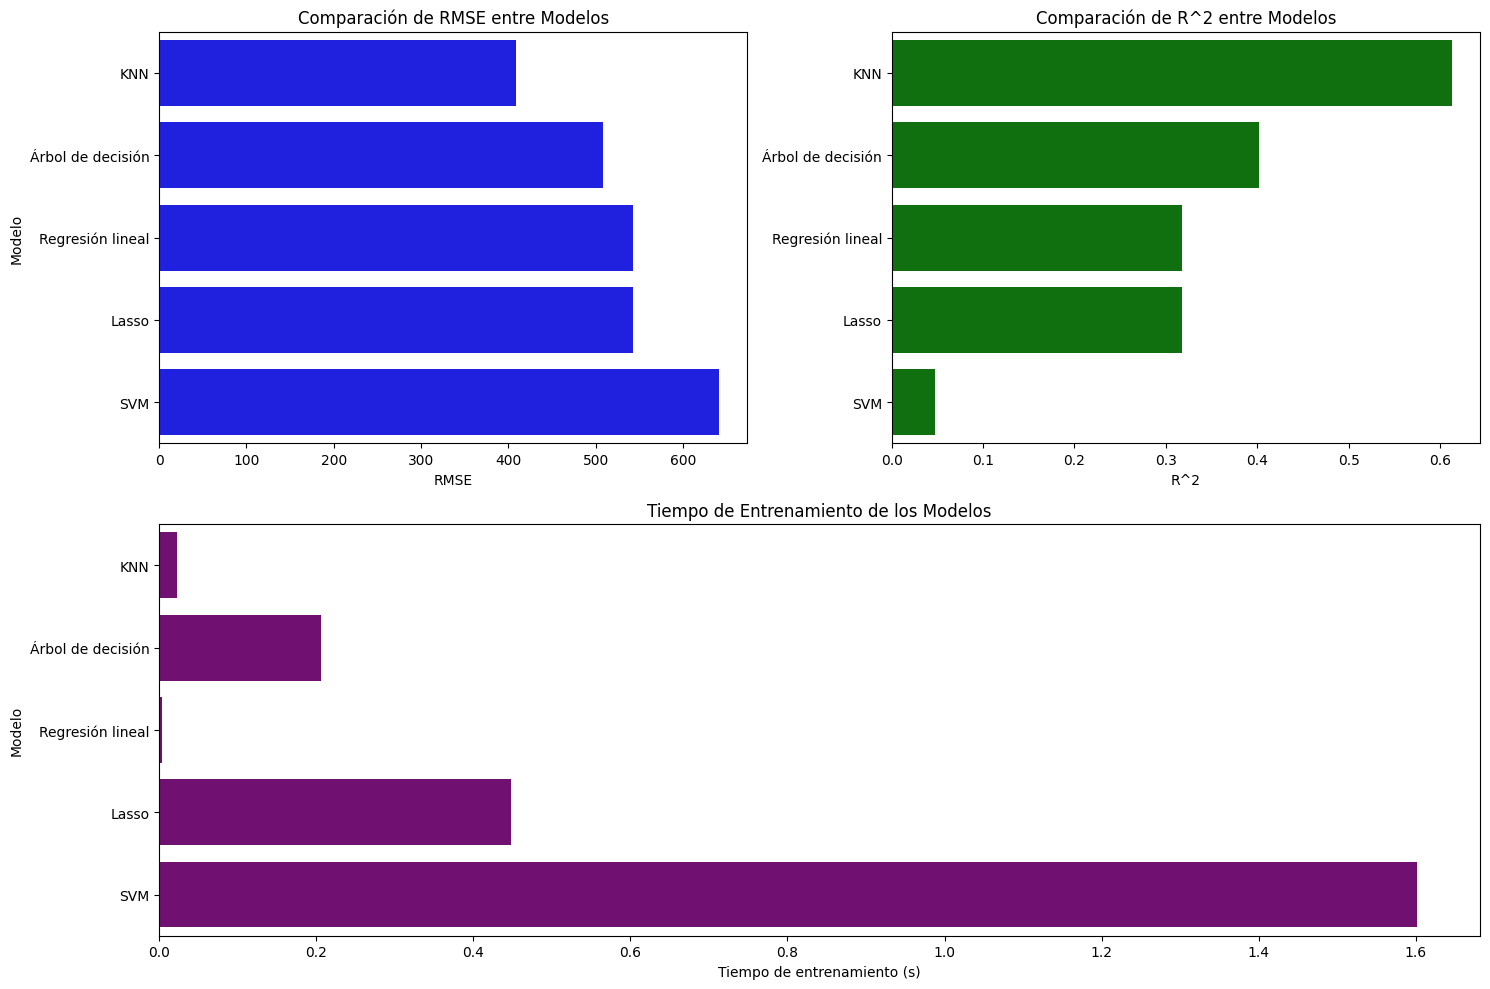

In [10]:
#Apartado 4a

# Aplicamos el StandardScaler que hemos elegido
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definimos los modelos a probar
modelos = {
    "KNN": KNeighborsRegressor(),
    "Árbol de decisión": DecisionTreeRegressor(),
    "Regresión lineal": LinearRegression(),
    "Lasso": Lasso(max_iter=10000, alpha=0.1),
    "SVM": SVR()
}

# Entrenamos y evaluamos los modelos
resultados = []
for nombre, modelo in modelos.items():
    inicio = time()
    modelo.fit(X_train_scaled, y_train)
    y_pred = modelo.predict(X_test_scaled)
    fin = time()
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    tiempo = fin - inicio
    resultados.append({"Modelo": nombre, "RMSE": rmse, "R^2": r2, "Tiempo de entrenamiento (s)": tiempo})

#Aqui imprimimos los modelos
resultados_df = pd.DataFrame(resultados)

resultados_df.sort_values(by=["RMSE", "R^2", "Tiempo de entrenamiento (s)"], ascending=[True, False, True], inplace=True)

# Imprimir la tabla ordenada
print("Tabla de Resultados Ordenada:")
print(resultados_df)

# Visualización de los resultados
plt.figure(figsize=(15, 10))

# Gráfico para RMSE
plt.subplot(2, 2, 1)
sns.barplot(data=resultados_df, x='RMSE', y='Modelo', color='blue')
plt.title('Comparación de RMSE entre Modelos')
plt.xlabel('RMSE')
plt.ylabel('Modelo')

# Gráfico para R^2
plt.subplot(2, 2, 2)
sns.barplot(data=resultados_df, x='R^2', y='Modelo', color='green')
plt.title('Comparación de R^2 entre Modelos')
plt.xlabel('R^2')
plt.ylabel('')

# Gráfico para el Tiempo de Entrenamiento
plt.subplot(2, 1, 2)
sns.barplot(data=resultados_df, x='Tiempo de entrenamiento (s)', y='Modelo', color='purple')
plt.title('Tiempo de Entrenamiento de los Modelos')
plt.xlabel('Tiempo de entrenamiento (s)')
plt.ylabel('Modelo')

plt.tight_layout()
plt.show()

In [11]:
#Apartado 4b
# Ahora buscamos los mejores hiperparametros para los modelos utilizados en el apartado 4a. La regresion lineal no tiene hiperparametros que ajustar
# Empezamos con los hiperparametros para ajustar el KNN
knn_params = {'n_neighbors': range(1, 31), 'weights': ['uniform', 'distance']}
knn_grid = GridSearchCV(KNeighborsRegressor(), knn_params, cv=5, scoring='neg_mean_squared_error')
knn_grid.fit(X_train_scaled, y_train)
print(f"Mejores hiperparámetros para KNN: {knn_grid.best_params_}")

Mejores hiperparámetros para KNN: {'n_neighbors': 12, 'weights': 'distance'}


In [12]:
# Hiperparametros para ajustar el arbol de decision
tree_params = {'max_depth': range(1, 21), 'min_samples_split': range(2, 21)}
tree_grid = GridSearchCV(DecisionTreeRegressor(), tree_params, cv=5, scoring='neg_mean_squared_error')
tree_grid.fit(X_train_scaled, y_train)
print(f"Mejores hiperparámetros para Árbol de Decisión: {tree_grid.best_params_}")

Mejores hiperparámetros para Árbol de Decisión: {'max_depth': 6, 'min_samples_split': 10}


In [13]:
# Hiperparametros para ajustar la regresion lasso
lasso_params = {'lasso__alpha': np.logspace(-3,3,200)}
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('lasso', Lasso(max_iter=100000))  
])
lasso_grid = GridSearchCV(lasso_pipeline, lasso_params, cv=5, scoring='neg_mean_squared_error')

lasso_grid.fit(X_train, y_train)
print(f"Mejores hiperparámetros para Lasso: {lasso_grid.best_params_}")

Mejores hiperparámetros para Lasso: {'lasso__alpha': 0.24094035602395245}


In [14]:
# Hiperparametros para ajustar el svm
svm_params = {'C': [500, 1000 ,1500, 2000], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear']}
svm_grid = GridSearchCV(SVR(), svm_params, cv=5, scoring='neg_mean_squared_error')
svm_grid.fit(X_train_scaled, y_train)
print(f"Mejores hiperparámetros para SVM: {svm_grid.best_params_}")

Mejores hiperparámetros para SVM: {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}


In [15]:
# Mejores hiperparámetros encontrados
knn_best_params = {'n_neighbors': 12, 'weights': 'distance'}
tree_best_params = {'max_depth': 6, 'min_samples_split': 10}
lasso_best_params = {'alpha': 0.24094035602395245}
svm_best_params = {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}

# Tiempos de entrenamiento con HPO
tiempos_hpo = []

# KNN
inicio = time()
knn_model = KNeighborsRegressor(**knn_best_params)
knn_model.fit(X_train_scaled, y_train)
fin = time()
tiempos_hpo.append(('KNN', fin - inicio))

# Árbol de decisión
inicio = time()
tree_model = DecisionTreeRegressor(**tree_best_params)
tree_model.fit(X_train_scaled, y_train)
fin = time()
tiempos_hpo.append(('Árbol de decisión', fin - inicio))

# Lasso
inicio = time()
lasso_model = Lasso(**lasso_best_params, max_iter=100000)
lasso_model.fit(X_train_scaled, y_train)
fin = time()
tiempos_hpo.append(('Lasso', fin - inicio))

# SVM
inicio = time()
svm_model = SVR(**svm_best_params)
svm_model.fit(X_train_scaled, y_train)
fin = time()
tiempos_hpo.append(('SVM', fin - inicio))

# Regresión Lineal
inicio = time()
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
fin = time()
tiempos_hpo.append(('Regresión lineal', fin - inicio))


# Imprimir tiempos de entrenamiento con HPO
for modelo, tiempo in tiempos_hpo:
    print(f"Tiempo de entrenamiento con HPO para {modelo}: {tiempo:.4f} segundos")


Tiempo de entrenamiento con HPO para KNN: 0.0013 segundos
Tiempo de entrenamiento con HPO para Árbol de decisión: 0.0617 segundos
Tiempo de entrenamiento con HPO para Lasso: 0.1511 segundos
Tiempo de entrenamiento con HPO para SVM: 0.9570 segundos
Tiempo de entrenamiento con HPO para Regresión lineal: 0.0060 segundos


Tabla de Resultados Ordenada:
              Modelo        RMSE       R^2  Tiempo de entrenamiento (s)
4                SVM  367.486189  0.687423                     1.633148
0                KNN  397.286069  0.634673                     0.031124
1  Árbol de decisión  420.891933  0.589969                     0.096751
2   Regresión lineal  542.744706  0.318185                     0.005950
3              Lasso  543.576594  0.316093                     0.150225


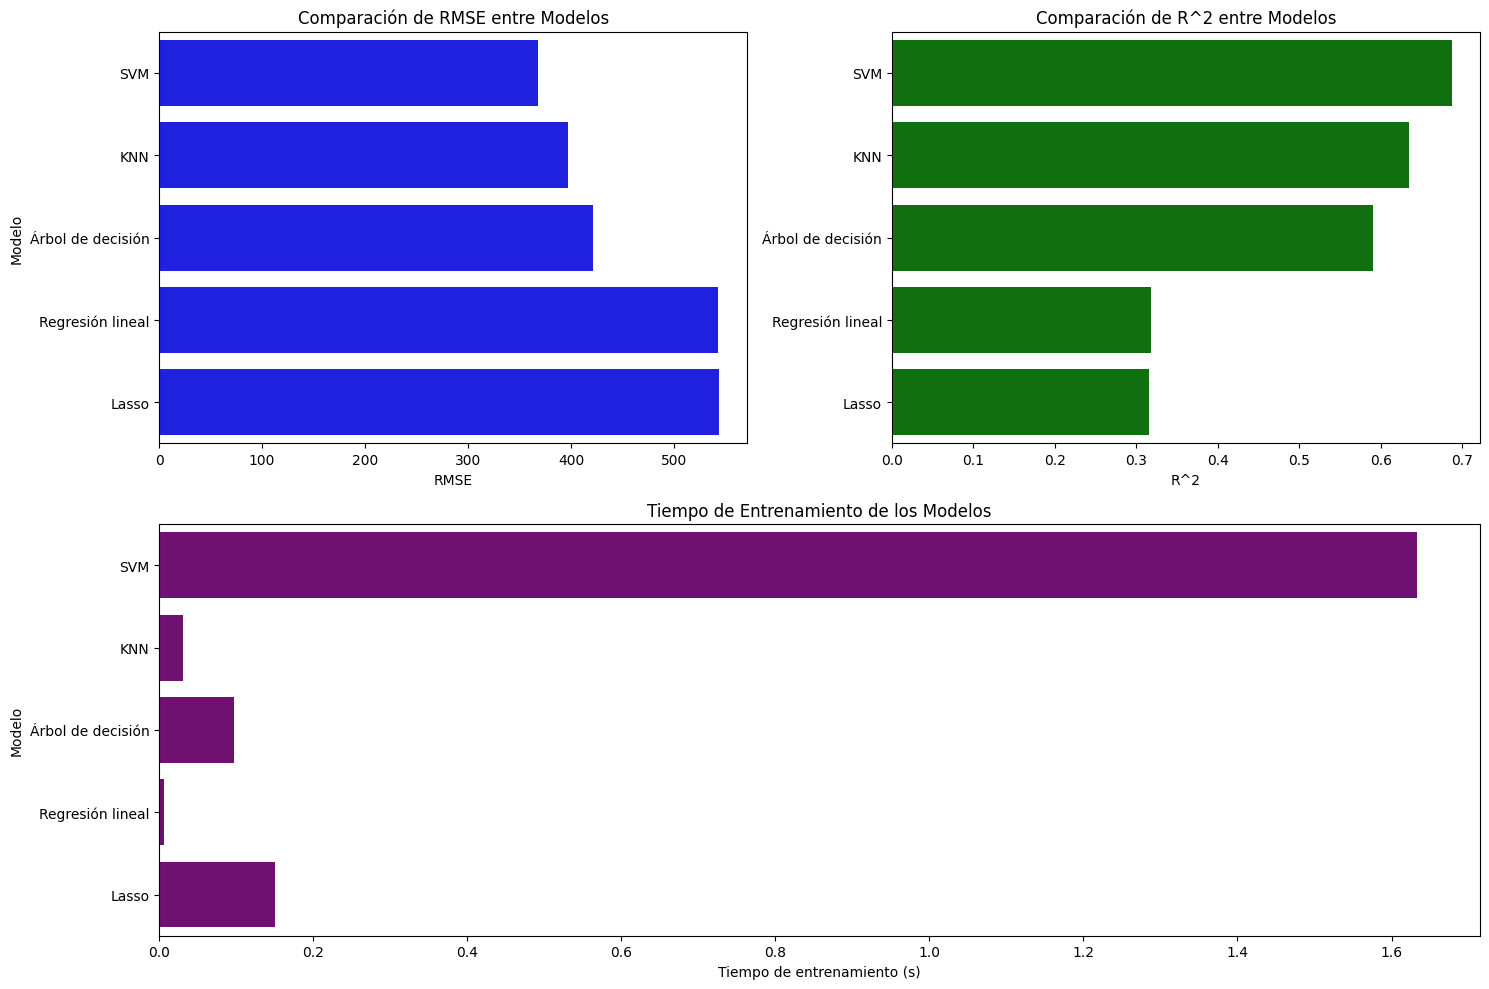

In [16]:
# Mejores hiperparámetros encontrados
knn_best_params = {'n_neighbors': 12, 'weights': 'distance'}
tree_best_params = {'max_depth': 6, 'min_samples_split': 10}
lasso_best_params = {'alpha': 0.24094035602395245, 'max_iter': 10000}
svm_best_params = {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}

# Tiempos de entrenamiento con HPO
tiempos_hpo = []

# Definimos los modelos
modelos = {
    "KNN": KNeighborsRegressor(**knn_best_params),
    "Árbol de decisión": DecisionTreeRegressor(**tree_best_params),
    "Regresión lineal": LinearRegression(),
    "Lasso": Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(**lasso_best_params))
    ]),
    "SVM": SVR(**svm_best_params)
}

# Entrenamos y evaluamos los modelos
resultados = []
for nombre, modelo in modelos.items():
    inicio = time()
    modelo.fit(X_train_scaled, y_train)
    y_pred = modelo.predict(X_test_scaled)
    fin = time()
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    tiempo = fin - inicio
    resultados.append({"Modelo": nombre, "RMSE": rmse, "R^2": r2, "Tiempo de entrenamiento (s)": tiempo})

#Aqui imprimimos los modelos
resultados_df = pd.DataFrame(resultados)

resultados_df.sort_values(by=["RMSE", "R^2", "Tiempo de entrenamiento (s)"], ascending=[True, False, True], inplace=True)

# Imprimir la tabla ordenada
print("Tabla de Resultados Ordenada:")
print(resultados_df)

# Visualización de los resultados
plt.figure(figsize=(15, 10))

# Gráfico para RMSE
plt.subplot(2, 2, 1)
sns.barplot(data=resultados_df, x='RMSE', y='Modelo', color='blue')
plt.title('Comparación de RMSE entre Modelos')
plt.xlabel('RMSE')
plt.ylabel('Modelo')

# Gráfico para R^2
plt.subplot(2, 2, 2)
sns.barplot(data=resultados_df, x='R^2', y='Modelo', color='green')
plt.title('Comparación de R^2 entre Modelos')
plt.xlabel('R^2')
plt.ylabel('')

# Gráfico para el Tiempo de Entrenamiento
plt.subplot(2, 1, 2)
sns.barplot(data=resultados_df, x='Tiempo de entrenamiento (s)', y='Modelo', color='purple')
plt.title('Tiempo de Entrenamiento de los Modelos')
plt.xlabel('Tiempo de entrenamiento (s)')
plt.ylabel('Modelo')

plt.tight_layout()
plt.show()

In [17]:
#Deducimos que el mejor modelo es el SVM ({'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}) al tener el menor RMSE y el mayor R2 

# Datos de entrada y salida completos
X = wind_ava_filtered.drop('energy', axis=1)
y = wind_ava_filtered['energy']

# Preprocesamiento y modelo con mejores hiperparámetros
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVR(C=1000, gamma='auto', kernel='rbf'))
])
pipeline.fit(X,y)

# Evaluación outer con validación cruzada
scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)

print(f"RMSE promedio en la evaluación outer: {rmse_scores.mean()}")


RMSE promedio en la evaluación outer: 376.4035080990517


In [18]:
#Punto 6.a: comparar el modelo de regresion para valores altos vs bajos de energia
# Calcular el tercer cuantil de la energía en el conjunto de entrenamiento
umbral_energia = y_train.quantile(0.75)

# Separar el conjunto de prueba en datos de baja y alta energía basados en el umbral a partir de sus indices
baja_energia_idx = y_test <= umbral_energia
alta_energia_idx = y_test > umbral_energia

X_test_baja_energia = X_test[baja_energia_idx]
y_test_baja_energia = y_test[baja_energia_idx]
X_test_alta_energia = X_test[alta_energia_idx]
y_test_alta_energia = y_test[alta_energia_idx]

# Usar el mejor modelo obtenido para hacer predicciones en ambos subconjuntos
y_pred_baja_energia = pipeline.predict(X_test_baja_energia)
y_pred_alta_energia = pipeline.predict(X_test_alta_energia)

# Calcular RMSE para las predicciones de baja y alta energía
rmse_baja_energia = np.sqrt(metrics.mean_squared_error(y_test_baja_energia, y_pred_baja_energia))
rmse_alta_energia = np.sqrt(metrics.mean_squared_error(y_test_alta_energia, y_pred_alta_energia))

print(f"RMSE para baja energía: {rmse_baja_energia}")
print(f"RMSE para alta energía: {rmse_alta_energia}")
# Podemos comprobar con éxito que el modelo elegido (knn con 10 vecinos y peso en distancia)
# trae un error más bajo con valores bajos de energia que con valores altos y mezclados respectivamente.

RMSE para baja energía: 254.04428405257823
RMSE para alta energía: 504.51120912501847
